In [1]:
import pystan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [46]:
# Generate some data
a = 2.5
b = 0.3
noise_sd = 0.3
n_data = 20

state = np.random.RandomState(3)

x = state.uniform(0, 1, size=n_data)
y = a * x + state.normal(scale=noise_sd, size=n_data) + b

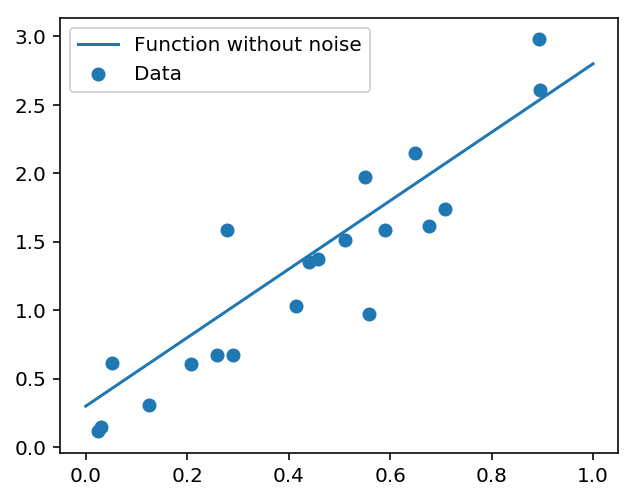

In [56]:
f, ax = plt.subplots(1, 1)

x_plot = np.linspace(0, 1, 20)
y_plot = a * x_plot + b

ax.scatter(x, y, label='Data')
ax.plot(x_plot, y_plot, label='Function without noise')
ax.legend()

f.set_size_inches(5, 4)

plt.savefig('../talks/august_2018_example_models/lin_reg_data.png', dpi=300)

In [85]:
model_code = """
data {
    int N; // number of data points
    vector[N] x; // Input
    vector[N] y; // Output
}
parameters {
    real a; // Slope
    real b; // Intercept
    real<lower=0> stdev; // Standard deviation of noise
}
model {
    y ~ normal(a * x + b, stdev);
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3234d0656863a3b939ed55560a37c072 NOW.


In [86]:
stan_data = {
    'N': n_data,
    'x': x,
    'y': y
}

fit = model.sampling(data=stan_data)

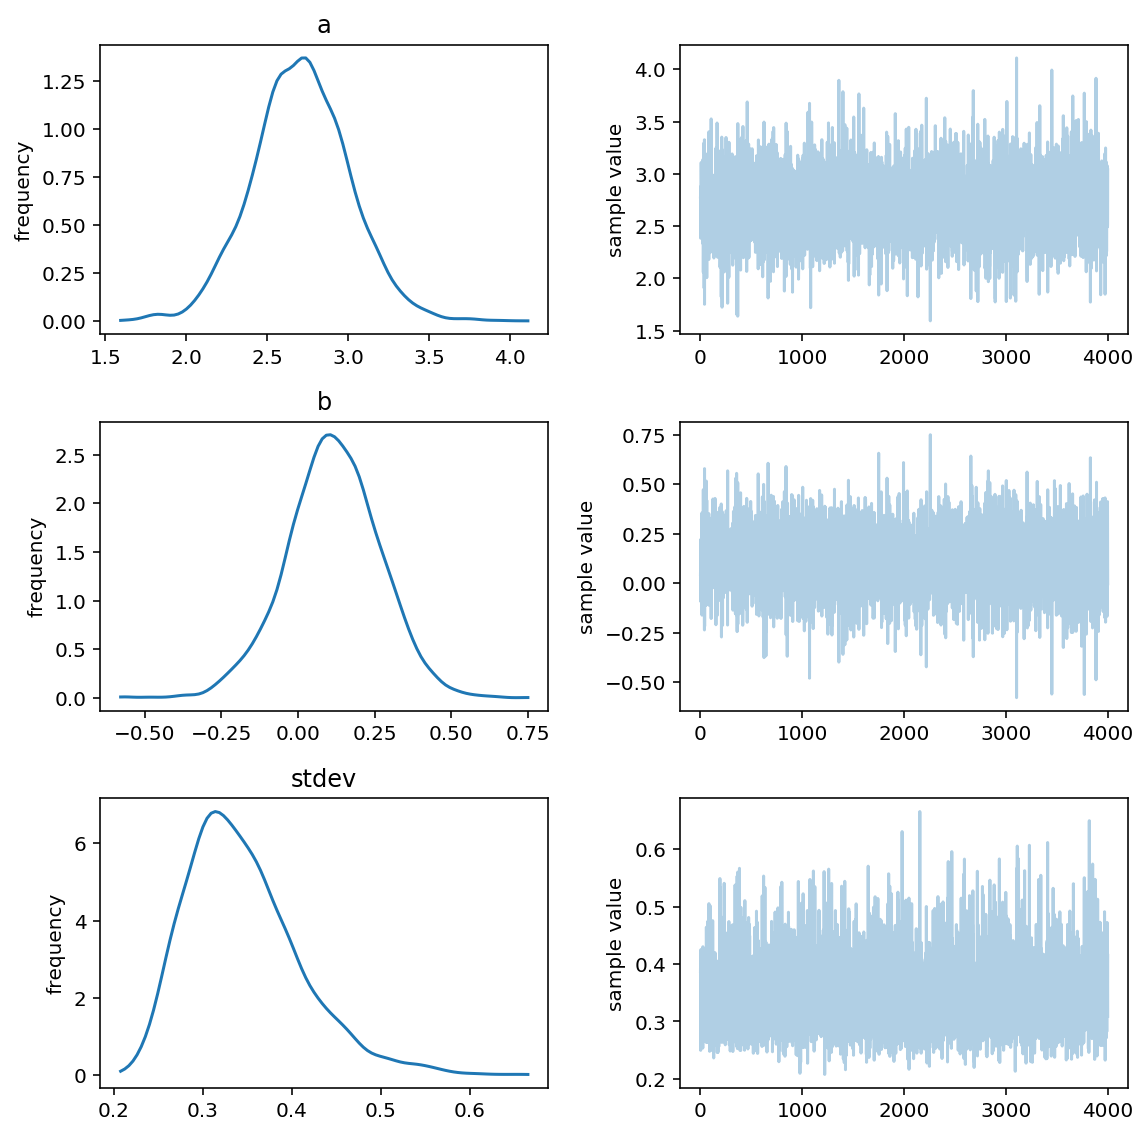

In [87]:
f = fit.plot()
f.set_size_inches(8, 8)
f.tight_layout()

In [88]:
print(fit)

Inference for Stan model: anon_model_3234d0656863a3b939ed55560a37c072.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a       2.71  8.0e-3    0.3   2.12   2.52   2.71   2.91    3.3 1395.0    1.0
b       0.11  4.1e-3   0.15   -0.2   0.02   0.12   0.21   0.41 1379.0    1.0
stdev   0.35  1.5e-3   0.06   0.25    0.3   0.34   0.38    0.5 1871.0    1.0
lp__   10.98    0.03   1.28   7.69  10.39  11.31  11.92  12.49 1465.0    1.0

Samples were drawn using NUTS at Thu Aug 30 18:53:34 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [89]:
# How does this compare to our known parameters?
samples = fit.extract()

In [90]:
a_samples = samples['a']
b_samples = samples['b']
stdev_samples = samples['stdev']

Text(0.5,1,u'Slope a')

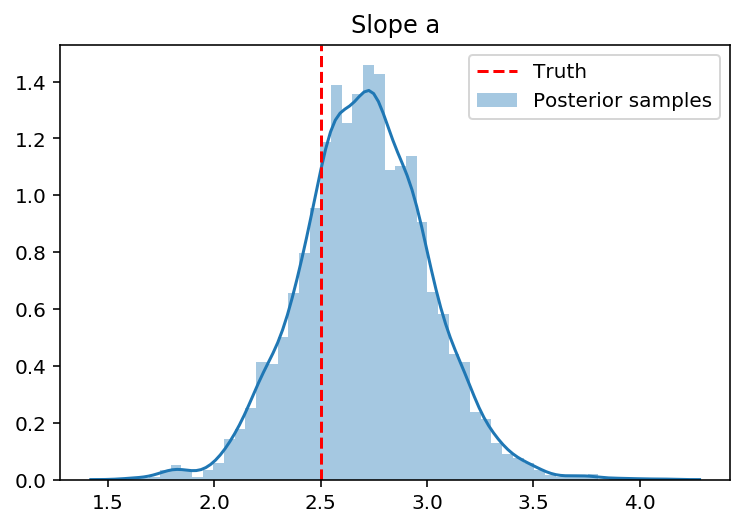

In [91]:
f, ax = plt.subplots(1, 1)

sns.distplot(a_samples, ax=ax, label='Posterior samples')
plt.axvline(a, color='r', linestyle='--', label='Truth')
plt.legend()
plt.title('Slope a')

Text(0.5,1,u'Intercept b')

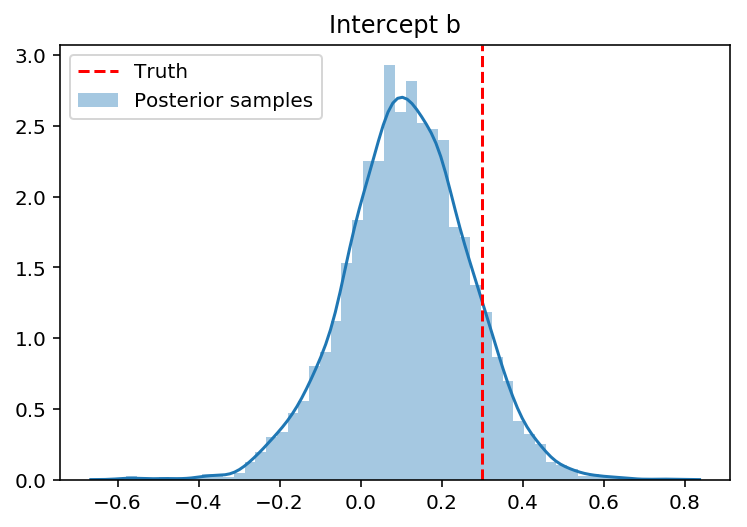

In [92]:
f, ax = plt.subplots(1, 1)

sns.distplot(b_samples, ax=ax, label='Posterior samples')
plt.axvline(b, color='r', linestyle='--', label='Truth')
plt.legend()
plt.title('Intercept b')

Text(0.5,1,u'Standard deviation of noise')

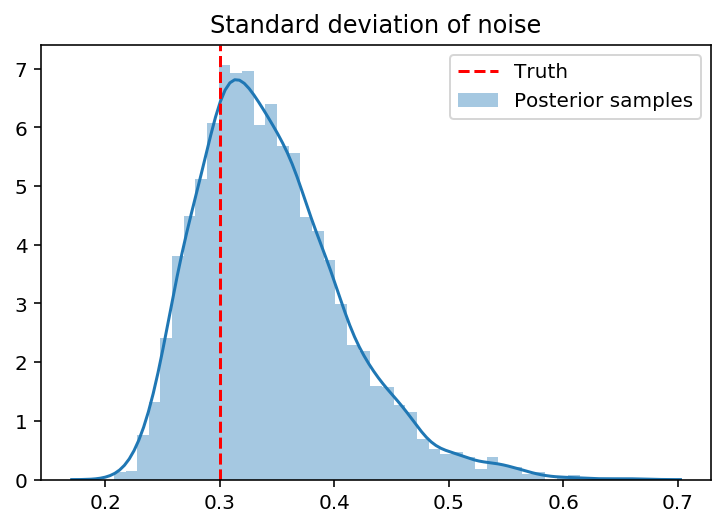

In [93]:
f, ax = plt.subplots(1, 1)

sns.distplot(stdev_samples, ax=ax, label='Posterior samples')
plt.axvline(noise_sd, color='r', linestyle='--', label='Truth')
plt.legend()
plt.title('Standard deviation of noise')

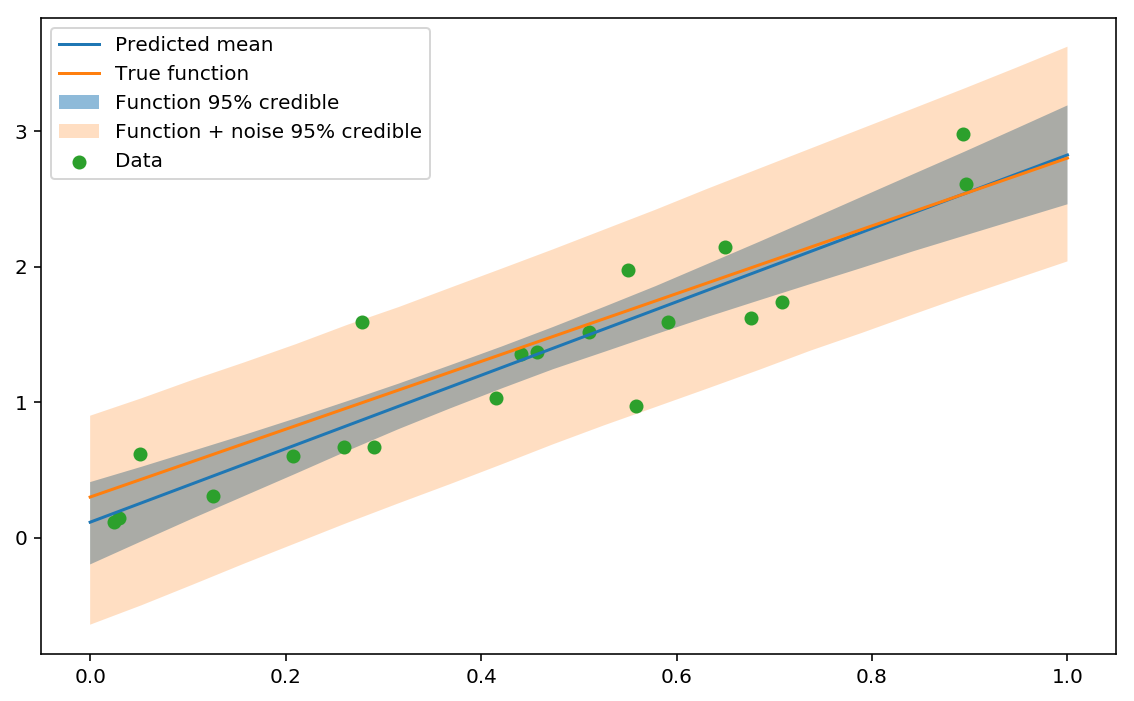

In [94]:
# We can plot our estimate of the function values, too
# Without noise
y_pred = x_plot.reshape(-1, 1) * a_samples + b_samples
y_pred_with_noise = y_pred + np.random.normal(scale=stdev_samples)

mean = y_pred.mean(axis=1)
lower = np.percentile(y_pred, 2.5, axis=1)
upper = np.percentile(y_pred, 97.5, axis=1)

lower_noise = np.percentile(y_pred_with_noise, 2.5, axis=1)
upper_noise = np.percentile(y_pred_with_noise, 97.5, axis=1)

plt.plot(x_plot, mean, label='Predicted mean')
plt.fill_between(x_plot, lower, upper, alpha=0.5, label='Function 95% credible')
plt.fill_between(x_plot, lower_noise, upper_noise, alpha=0.25, label='Function + noise 95% credible')
plt.plot(x_plot, y_plot, label='True function')
plt.scatter(x, y, label='Data')

plt.legend()

plt.gcf().set_size_inches(8, 5)
plt.gcf().tight_layout()